# Labelling nodes and edges

When building networks with fine structure we offten need to proceed carefully, creating the final network from small component networks and then joining these together to get the final system. In this notebook we'll look at one example of this general technique: how to combine two networks together to get a modular network with two modules. The same techniques can be used when creating multilayer networks.

We'll develop the operation as a collection of functions so that we can comment on each one as we go. In practice we'd probably wrap all this code up into a single network generator.


In [1]:
# networks
import networkx
from numpy.random import default_rng
from itertools import combinations

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## Creating the modules

We'lkl begin by creating the modules. We'll assume for this exercise that we want ER networks with given size and mean degree. We'll label each module with a "colour" &ndash; it doesn't have to be a colour, of course, it's just a tag so we can identify the modules later.

In [2]:
def makeModule(N, kmean, c):
    '''Make an ER module, labelled with the appropriate "colour".
    
    :param N: the size of the module
    :param kmean: the mean degree
    :param c: the colour tag
    :returns: an ER network'''
    
    # create the network
    g = networkx.fast_gnp_random_graph(N, (kmean / N))
    
    # colour all the nodes and edges
    networkx.set_node_attributes(g, name="colour", values=c)
    networkx.set_edge_attributes(g, name="colour", values=c)
    
    return g

## Combining the modules

We then want to combine the modules into a single network. `networkx` insists that all nodes ina  network have a unique label, and &ndash; since we created our modules quite na&iuml;vely &ndash; we'll have the default labels for *each* module the same. We can correct this by using a function `convbert_node_labels_to_integers`, whiuch does exactly what it sounds like but also lets is specify the starting integer in the sequence, which means we can relabel each node uniquely just by keeping track of the number of nodes added so far. We then use the `compose` function that joins networks together.

In [3]:
def combineNetworks(gs):
    '''Combine a collection of networks into a single network, relabelling
    the nodes to ensure they're all unique.
    
    :param gs: the networks
    :returns: a single network'''
    g = networkx.Graph()
    
    # relabel and add each component network
    i = 0
    for h in gs:
        # relabel to unique integer sequence
        hprime = networkx.convert_node_labels_to_integers(h, first_label=i)
        i += hprime.order()
        
        # add the networks together
        g = networkx.compose(g, hprime)
        
    return g 

Finally we add a single edge between each module, by choosing a node at random with the correct colour. We do this for all combinations of colours.

In [4]:
def linkNetworks(g, cs):
    '''Add a single link between each pair of modules.
    
    :param g: the network
    :param cs: the colours of the modules
    :returns: the network with the links added'''
    rng = default_rng()
    
    for p in combinations(cs, 2):
        # find the nodes of each colour
        ns0 = [n for n in g.nodes() if g.nodes[n]["colour"] == p[0]]
        ns1 = [n for n in g.nodes() if g.nodes[n]["colour"] == p[1]]
        
        # choose a random pair and link them
        n0 = rng.choice(ns0)
        n1 = rng.choice(ns1)
        g.add_edge(n0, n1)
        
    return g

## Constructing the network

We can now use these functions to create our modular network. For simplicity we'll use the same topology for each &ndash; they could be varied, of course &ndash; and label each module with a colour.

In [14]:
N = 500
kmean = 15

colours = ['red', 'green', 'blue', 'purple', 'yellow', 'black']

In [16]:
ms = [makeModule(N, kmean, c) for c in colours]

Let's check to make sure that each module is a single component.

In [7]:
print("Number of connected components in each module:")
for m in ms:
    print(f'{networkx.number_connected_components(m)} ({m.order()} nodes)')

Number of connected components in each module:
1 (500 nodes)
1 (500 nodes)
1 (500 nodes)
1 (500 nodes)
1 (500 nodes)
1 (500 nodes)


(If this wasn't the case we'd probably want to extract the largest connected component from each module.) We can then combine the modules together.

In [8]:
g = combineNetworks(ms)

In [9]:
print(f'Size of combined network is {g.order()} nodes')

Size of combined network is 3000 nodes


In [10]:
linkNetworks(g, colours)

## Checking correctness

At this point you might want to draw a picture of the final network.

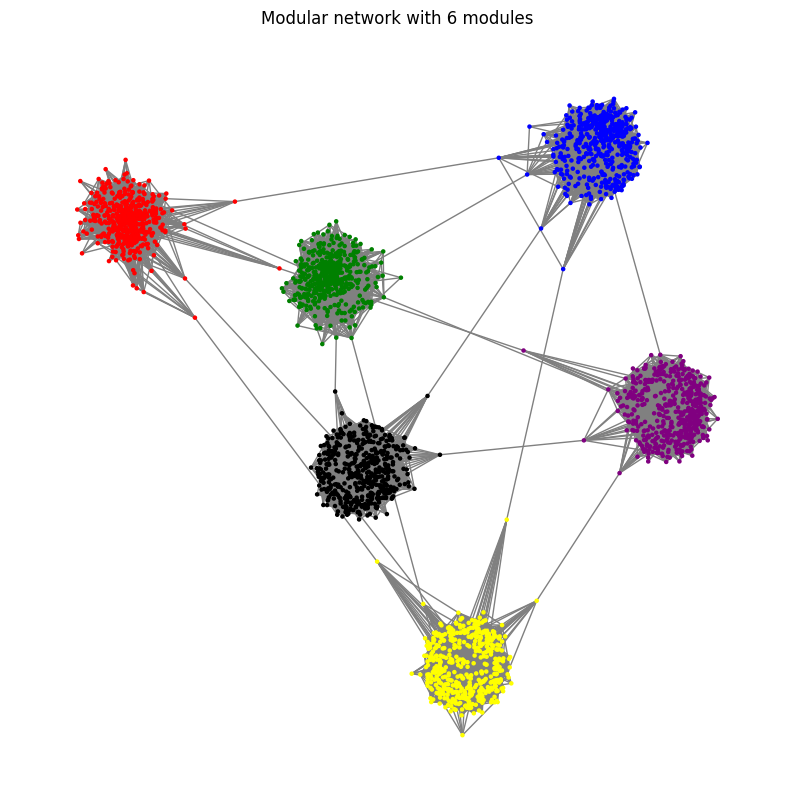

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

# compute the positions of nodes using a spring layout
pos = networkx.spring_layout(g, threshold=1e-3)

# assign the correct colours to each node, according to its module
nodeColours = [g.nodes[n]["colour"] for n in g.nodes()]

# draw the network
networkx.draw(g,
              pos=pos,                         # node positions
              node_color=nodeColours,          # node colours (by module)
              node_size=5, edge_color='gray')  # fine-tuning

plt.title(f'Modular network with {len(colours)} modules')

plt.show()

However, pretty as that is, it's not all that informative: you can perhaps convince yourself that there's only a single edge between each pair of modules, but how do we know for sure we've got exactly what we asked for? We can do better by performing some algorithmic tests.

Firstly, the network should be connected, since each module is connected itself and there's an edge between each pair.

In [11]:
networkx.number_connected_components(g)

1

The number of nodes of each colour should have been conserved.

In [12]:
print("Number of nodes of each colour:")
for i in range(len(ms)):
    print('{c}: {n}'.format(c=colours[i],
                            n=len([n for n in g.nodes() if g.nodes[n]["colour"] == colours[i]])))

Number of nodes of each colour:
red: 500
green: 500
blue: 500
purple: 500
yellow: 500
black: 500


And finally we want one edge between each pair of modules, which is to say between each set of nodes of a given colour for all pairs of colours.

In [13]:
print('Number of edges between each pair of modules:')
for p in combinations(colours, 2):
    print('{c}-{d}: {n}'.format(c=p[0], d=p[1],
                                n=len([e for e in g.edges() if g.nodes[e[0]]["colour"] == p[0] and g.nodes[e[1]]["colour"] == p[1]])))

Number of edges between each pair of modules:
red-green: 1
red-blue: 1
red-purple: 1
red-yellow: 1
red-black: 1
green-blue: 1
green-purple: 1
green-yellow: 1
green-black: 1
blue-purple: 1
blue-yellow: 1
blue-black: 1
purple-yellow: 1
purple-black: 1
yellow-black: 1


There are probably more checks we can do, including making sure that the degree distributions are the same and what impact the intermodule links have had &ndash; if any.